<a href="https://colab.research.google.com/github/MazonSzymon/modelowanie_cen_akcji_spolek/blob/main/Praca_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  ***Modelowanie  cen  (zwrotów  ceny)  akcji  spółek:  Alior Bank, mBank, Dino Polska, CD Projekt  przy  użyciu  modeli szeregów czasowych ARMA, ARIMA*** 

---

#Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as pdr 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
%load_ext google.colab.data_table




#Set up plot
from cycler import cycler
plt.style.use('ggplot')
plt.rc('axes', facecolor='white', edgecolor='black', grid = False, axisbelow = True)
plt.rc('grid',color='gray', linestyle='solid', linewidth=0.5)
plt.rc('patch', edgecolor='black')
plt.rc('legend', shadow=True, handlelength=1, fontsize=10, edgecolor = 'black', facecolor='white')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [3]:
!git clone https://github.com/MazonSzymon/modelowanie_cen_akcji_spolek.git
import sys
sys.path.append('/content/modelowanie_cen_akcji_spolek/')

fatal: destination path 'modelowanie_cen_akcji_spolek' already exists and is not an empty directory.


# Stooq data

>## Stocks company list




In [5]:
our_stocks = pd.DataFrame(np.array([
                                    ['WI20','wig20.pl'],
                                    ['Alior Bank','alr.pl'],
                                    ['CD Projekt', 'cdr.pl'],
                                    ['Dino Polska', 'dnp.pl'],
                                    ['mBank', 'mbk.pl']
]), columns = ['Full_name','Stoq_name'])



>## Download data and main DataFrame functions



In [4]:
def get_data(stock,start_date, end_date):
  stooq_data = pdr.get_data_stooq(stock['Stoq_name'], start = start_date, end = end_date).sort_index()
  stooq_data['Stock_name'] = stock['Full_name']
  df = stooq_data.copy()
  return df

In [6]:
def creat_WIG20_frame(start_date,end_date,stocks_list):
  WIG20 = pd.DataFrame()
  for i in range(len(stocks_list)):
    tmp = get_data(stocks_list.iloc[i],start_date,end_date)
    WIG20 = WIG20.append(tmp)
  return WIG20



>## Main DataFrame



>> ### Creat main DataFrame





In [7]:
start_date = dt.date(2020,1,1)
end_date = dt.date.today()
df = creat_WIG20_frame(start_date,end_date,our_stocks) #API, dont run many times!

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-01-02 to 2020-11-10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1095 non-null   float64
 1   High        1095 non-null   float64
 2   Low         1095 non-null   float64
 3   Close       1095 non-null   float64
 4   Volume      1095 non-null   int64  
 5   Stock_name  1095 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 59.9+ KB


In [9]:
df.drop( columns= ['Open','High','Low','Volume'],inplace = True)
df['Stock_name'] = df['Stock_name'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-01-02 to 2020-11-10
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Close       1095 non-null   float64 
 1   Stock_name  1095 non-null   category
dtypes: category(1), float64(1)
memory usage: 18.4 KB


>> ### Data Visualization

 



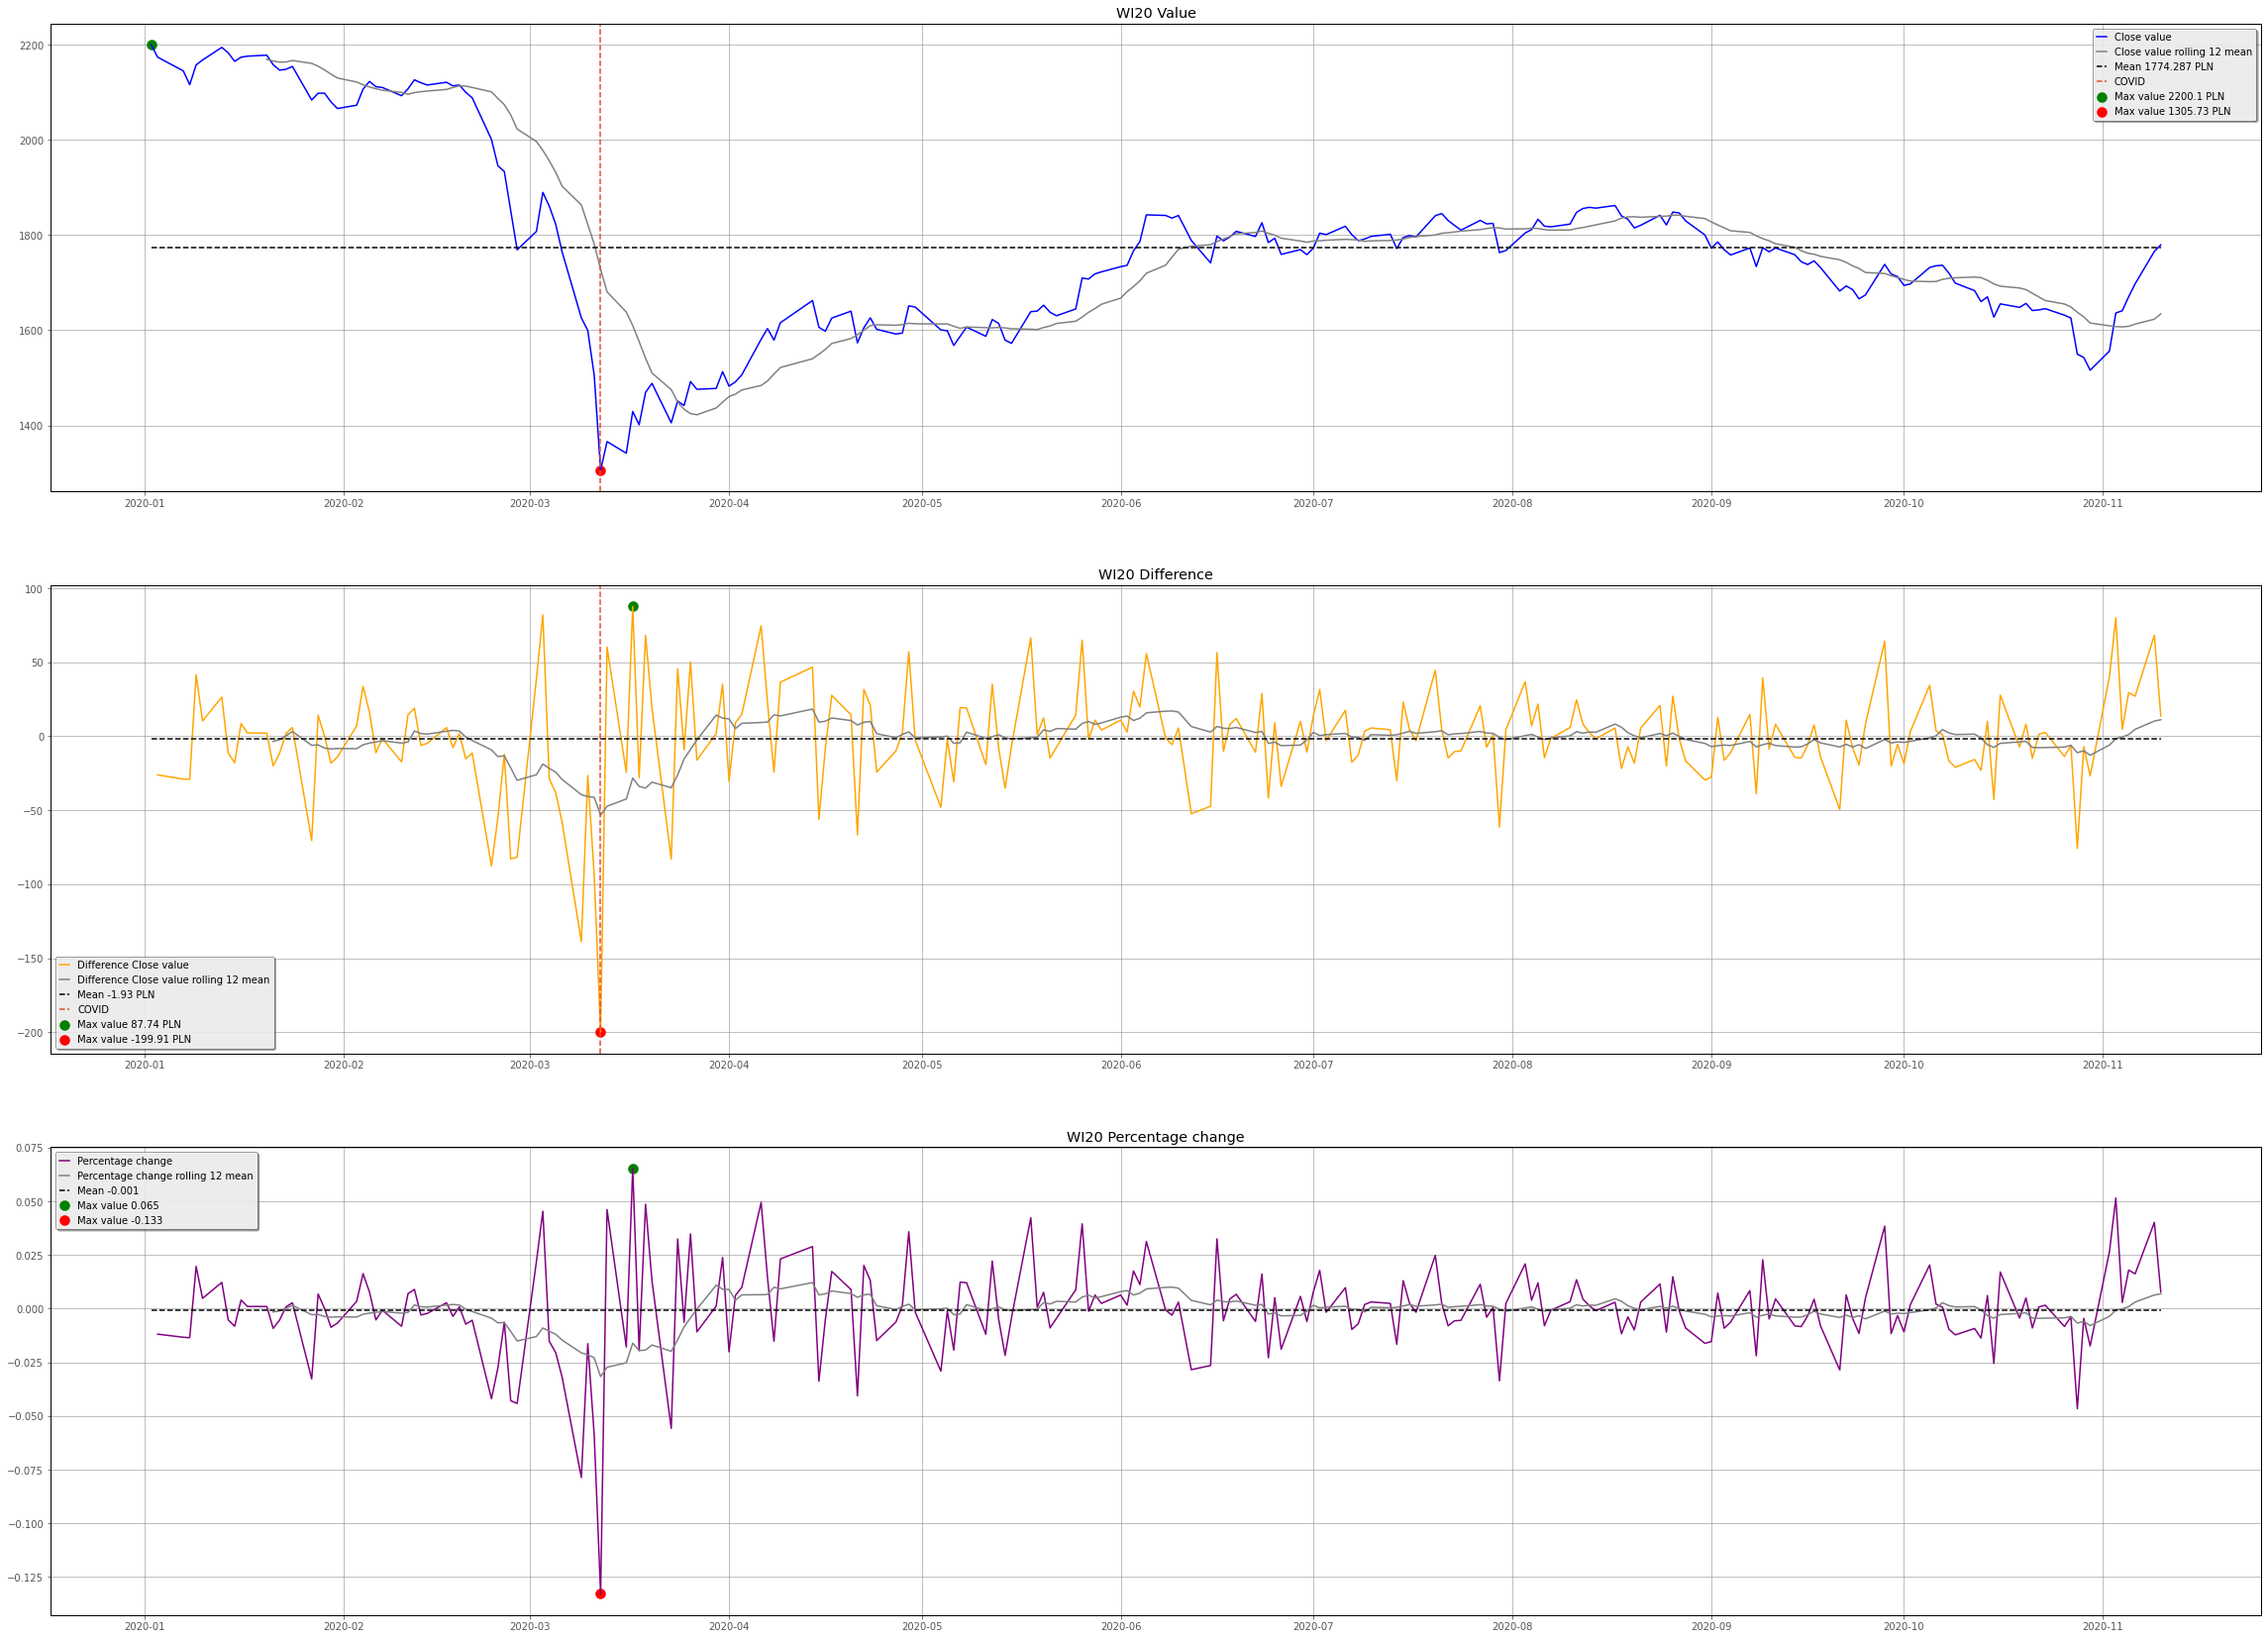

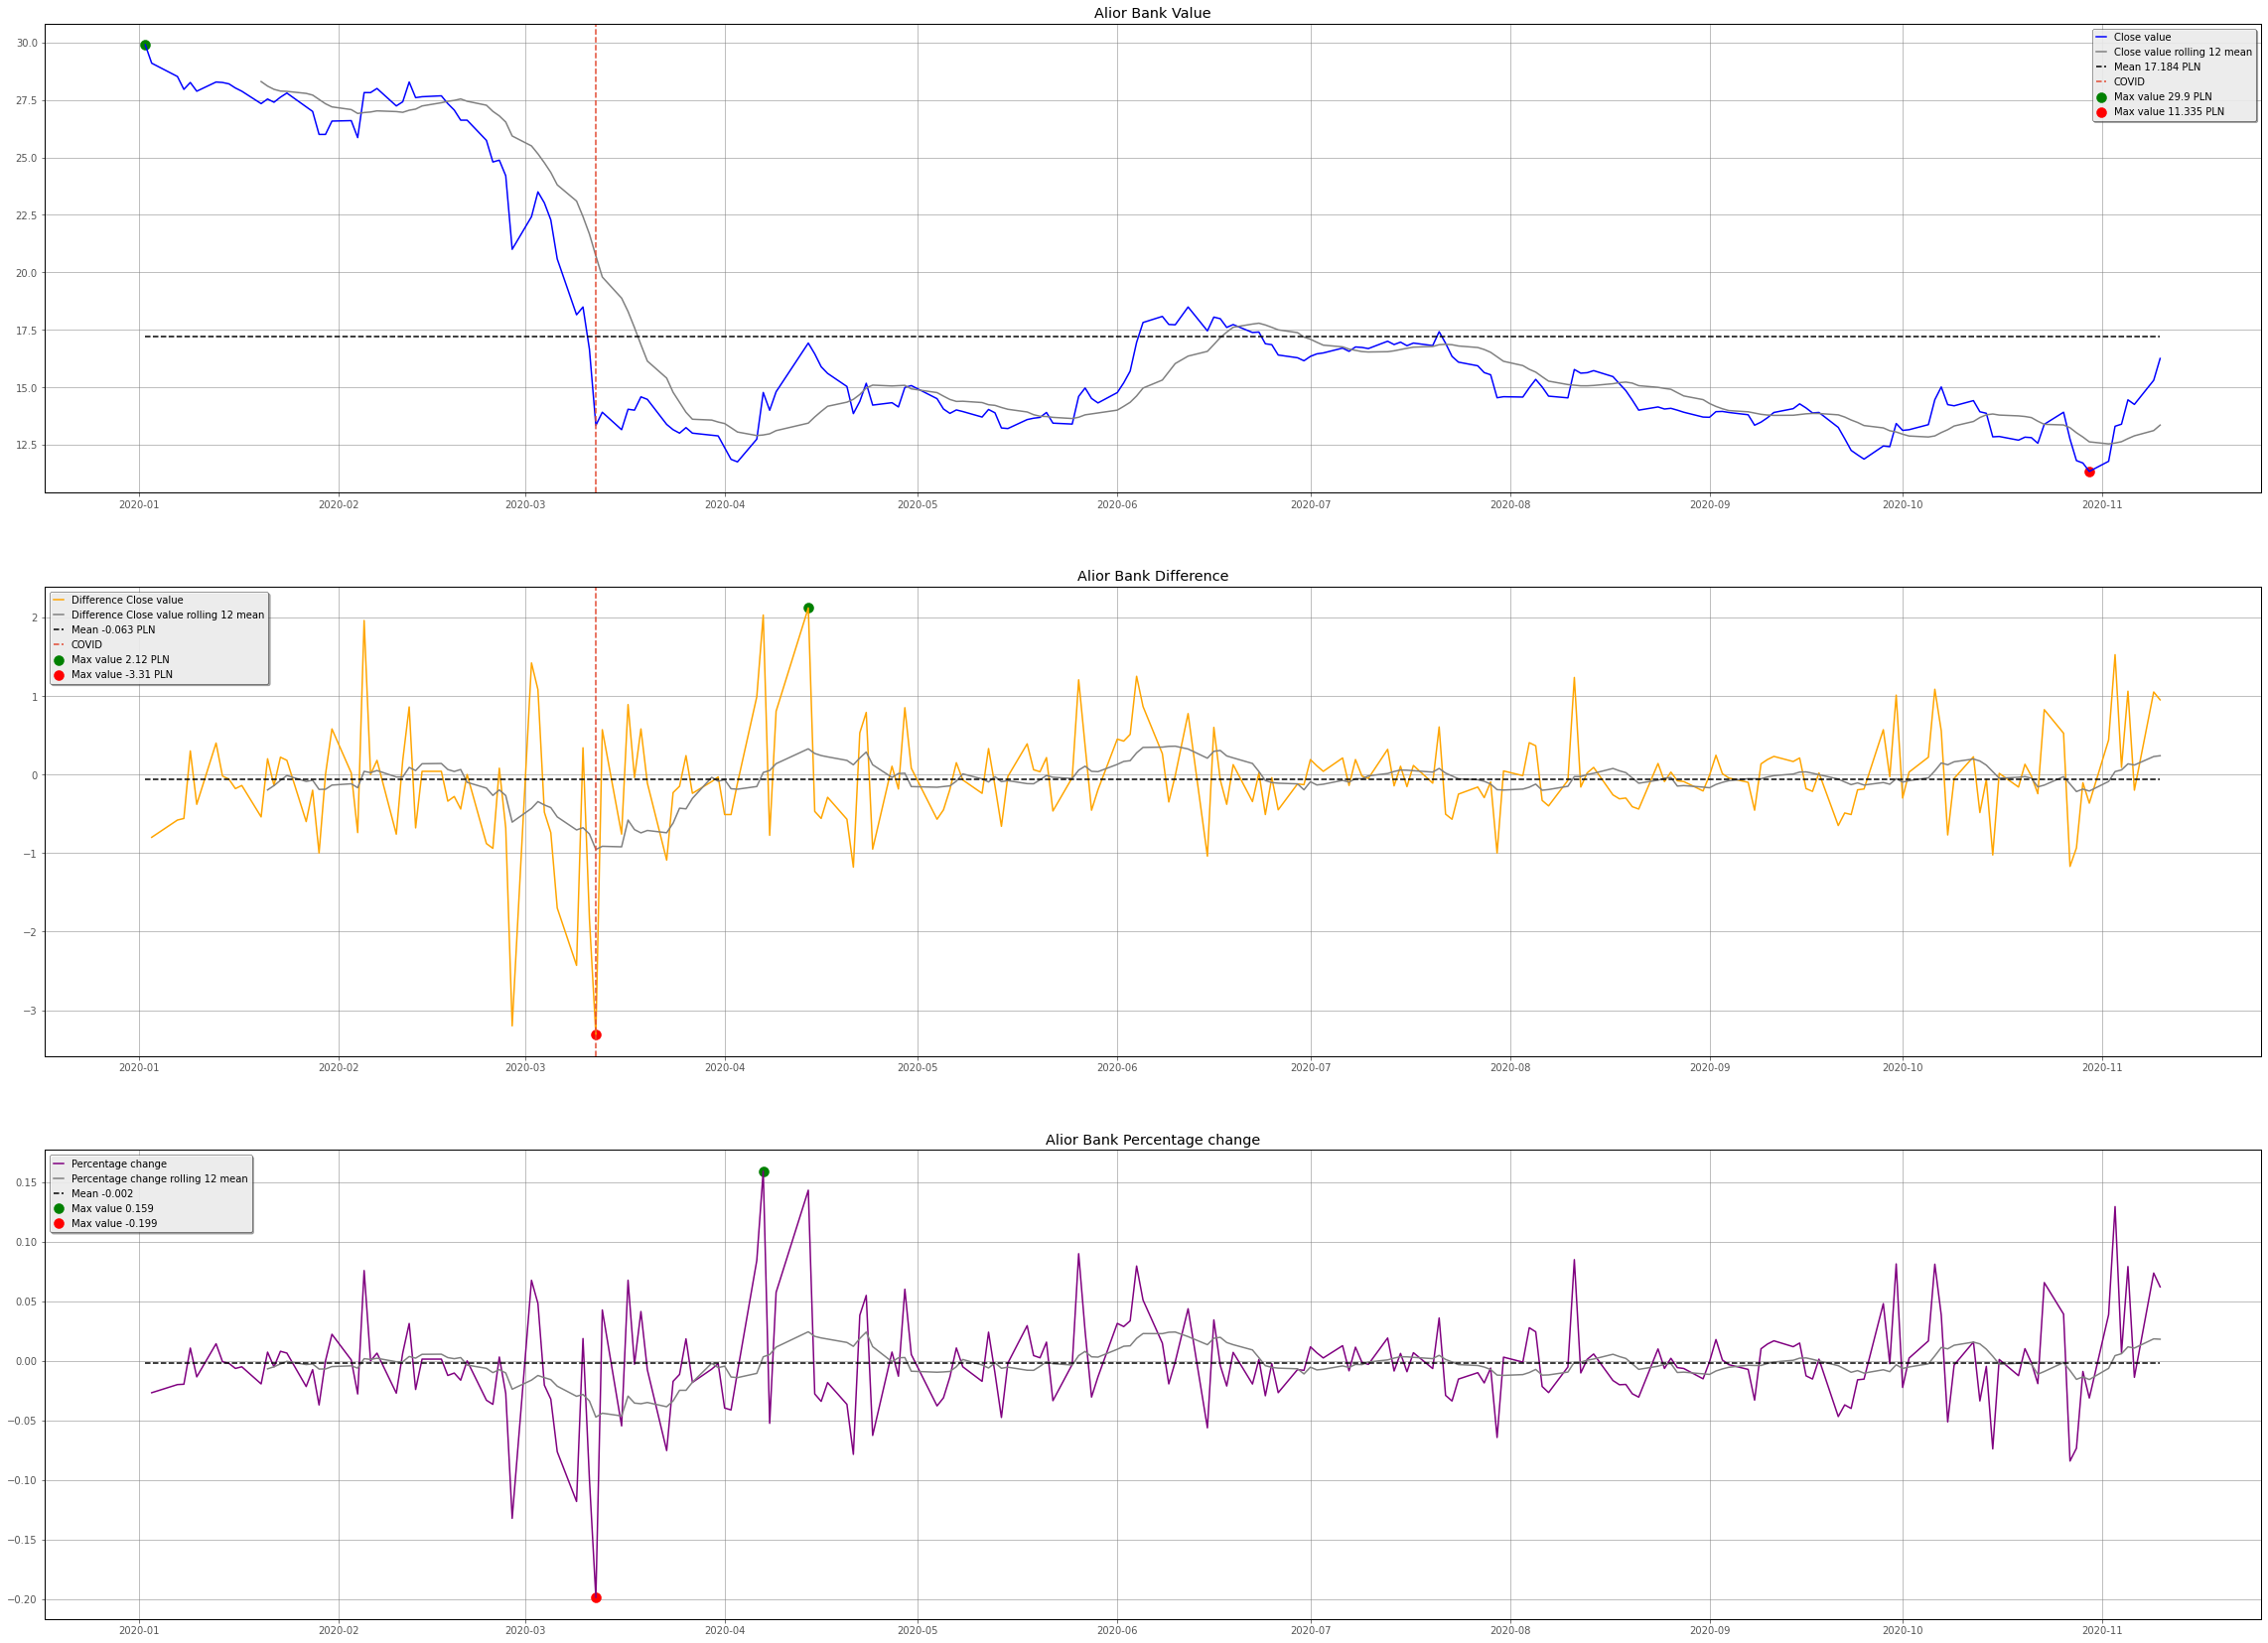

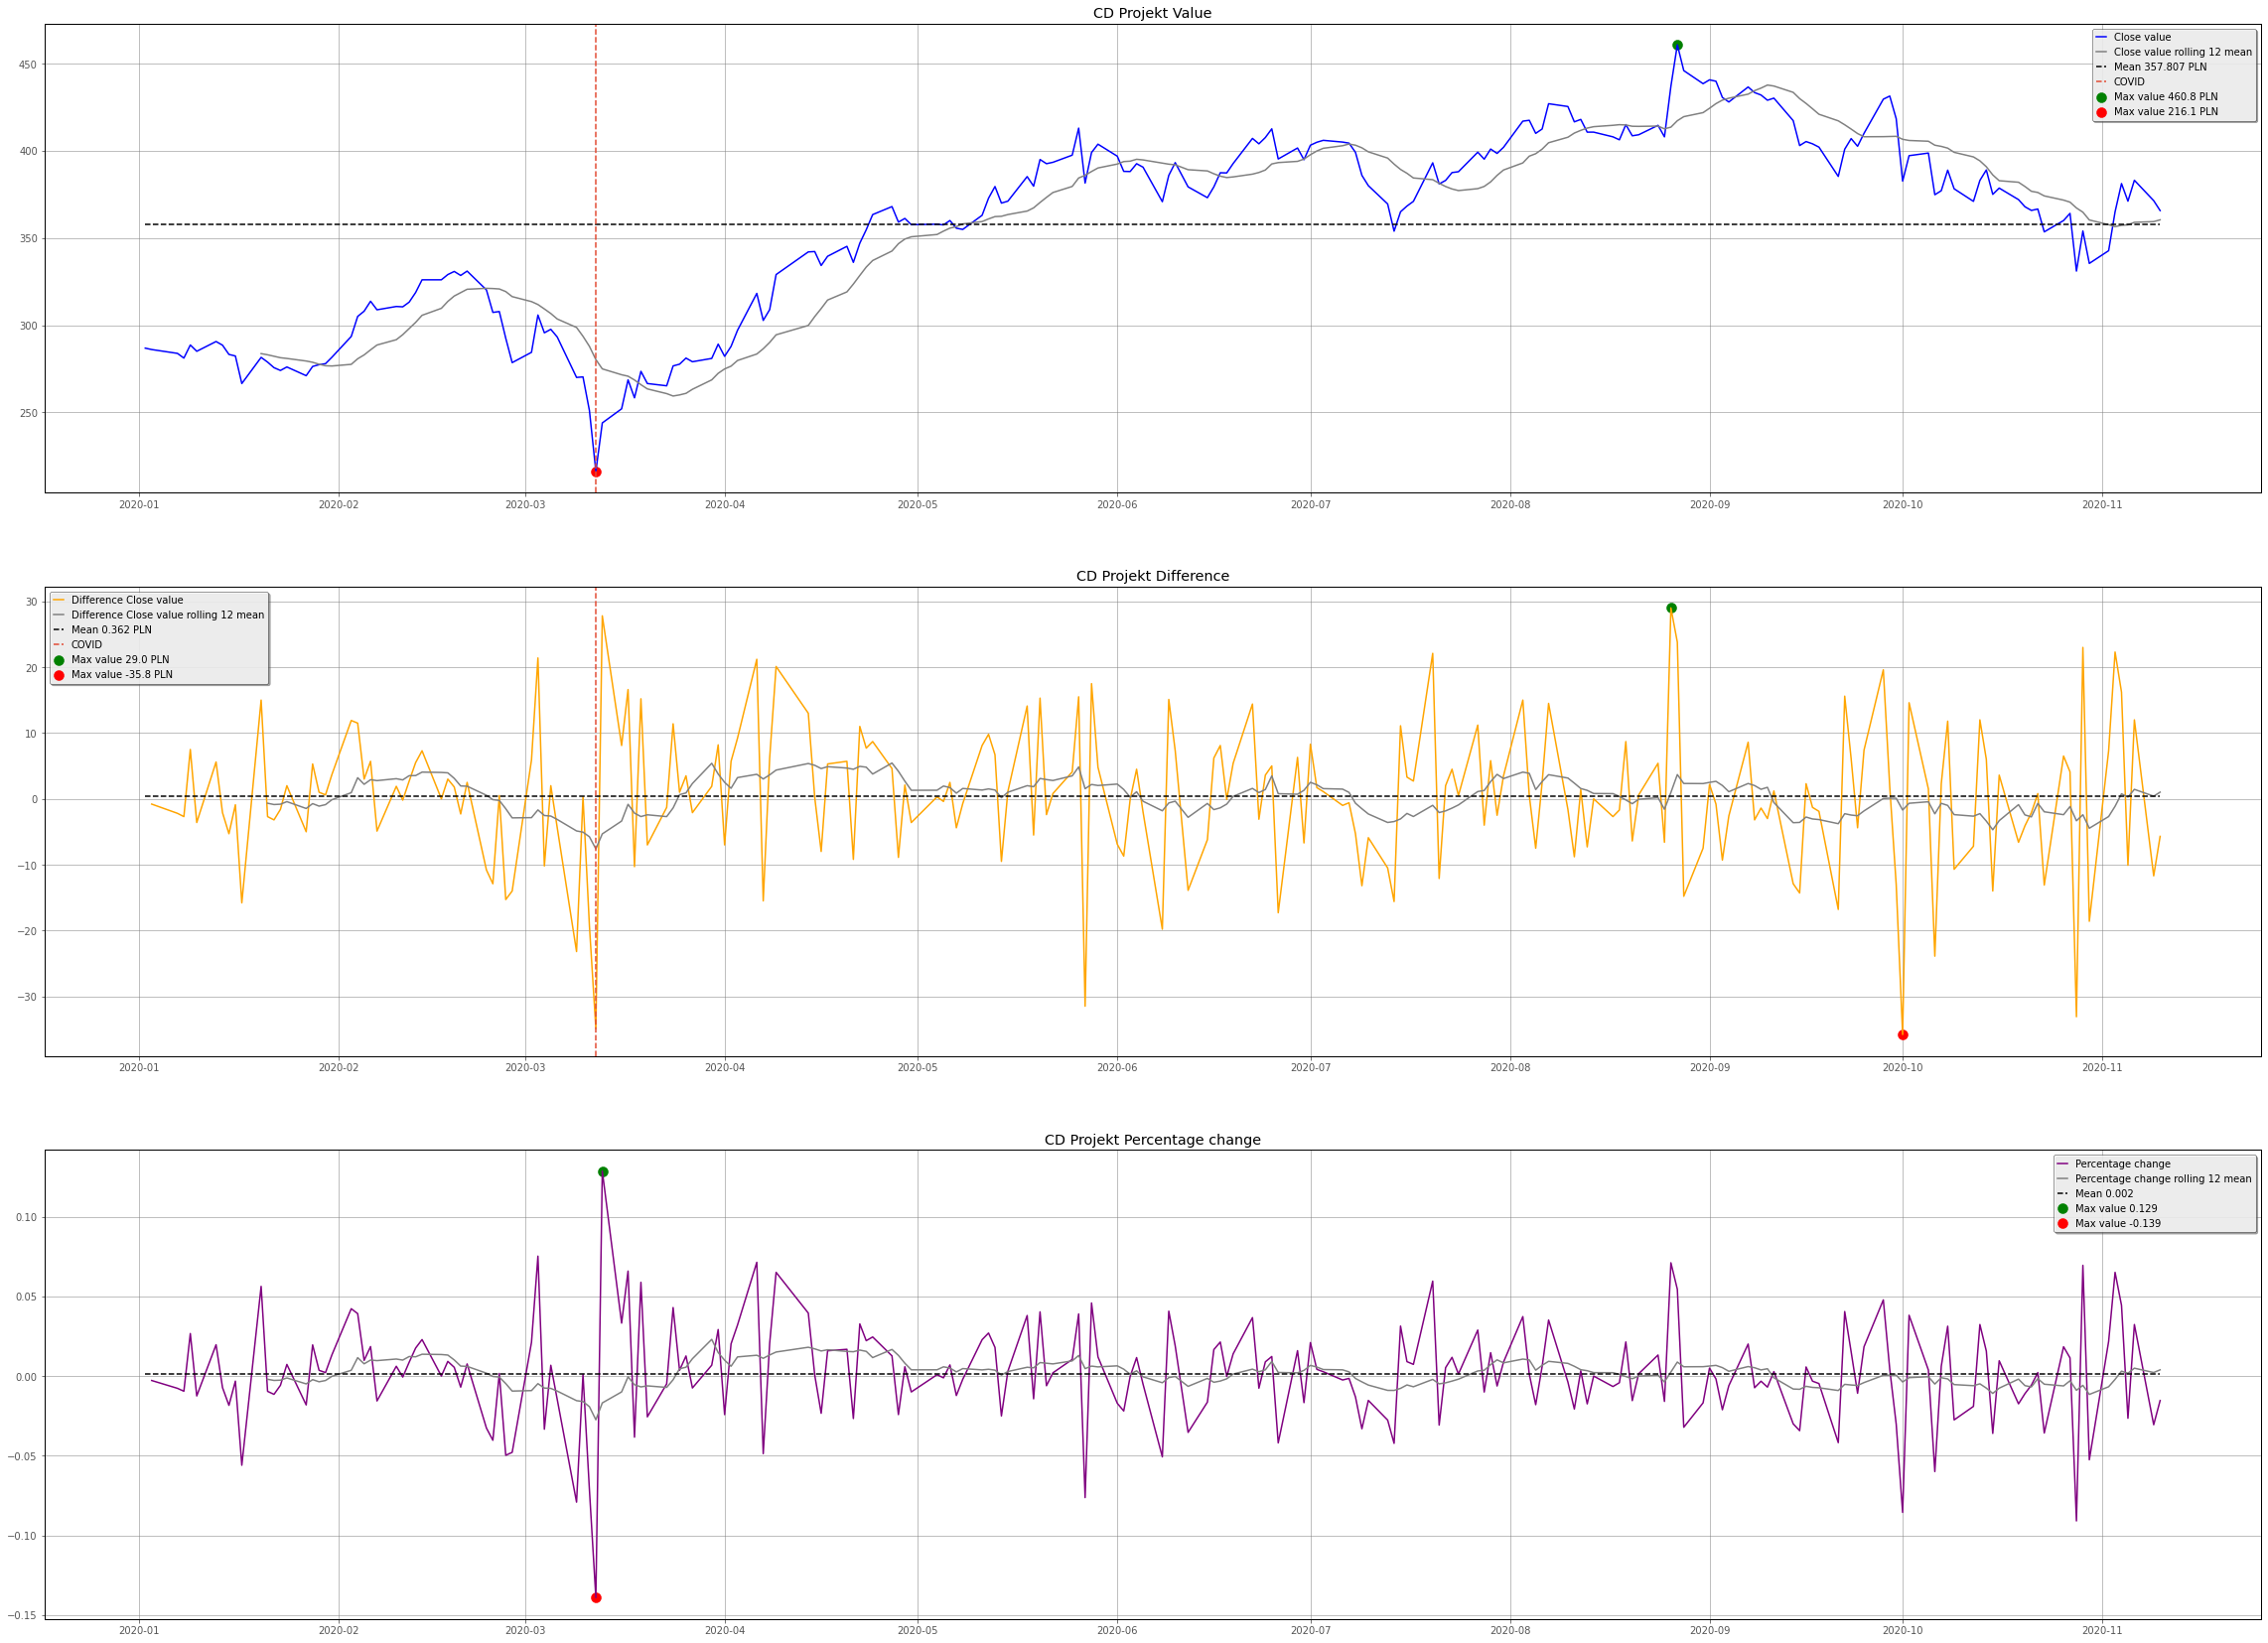

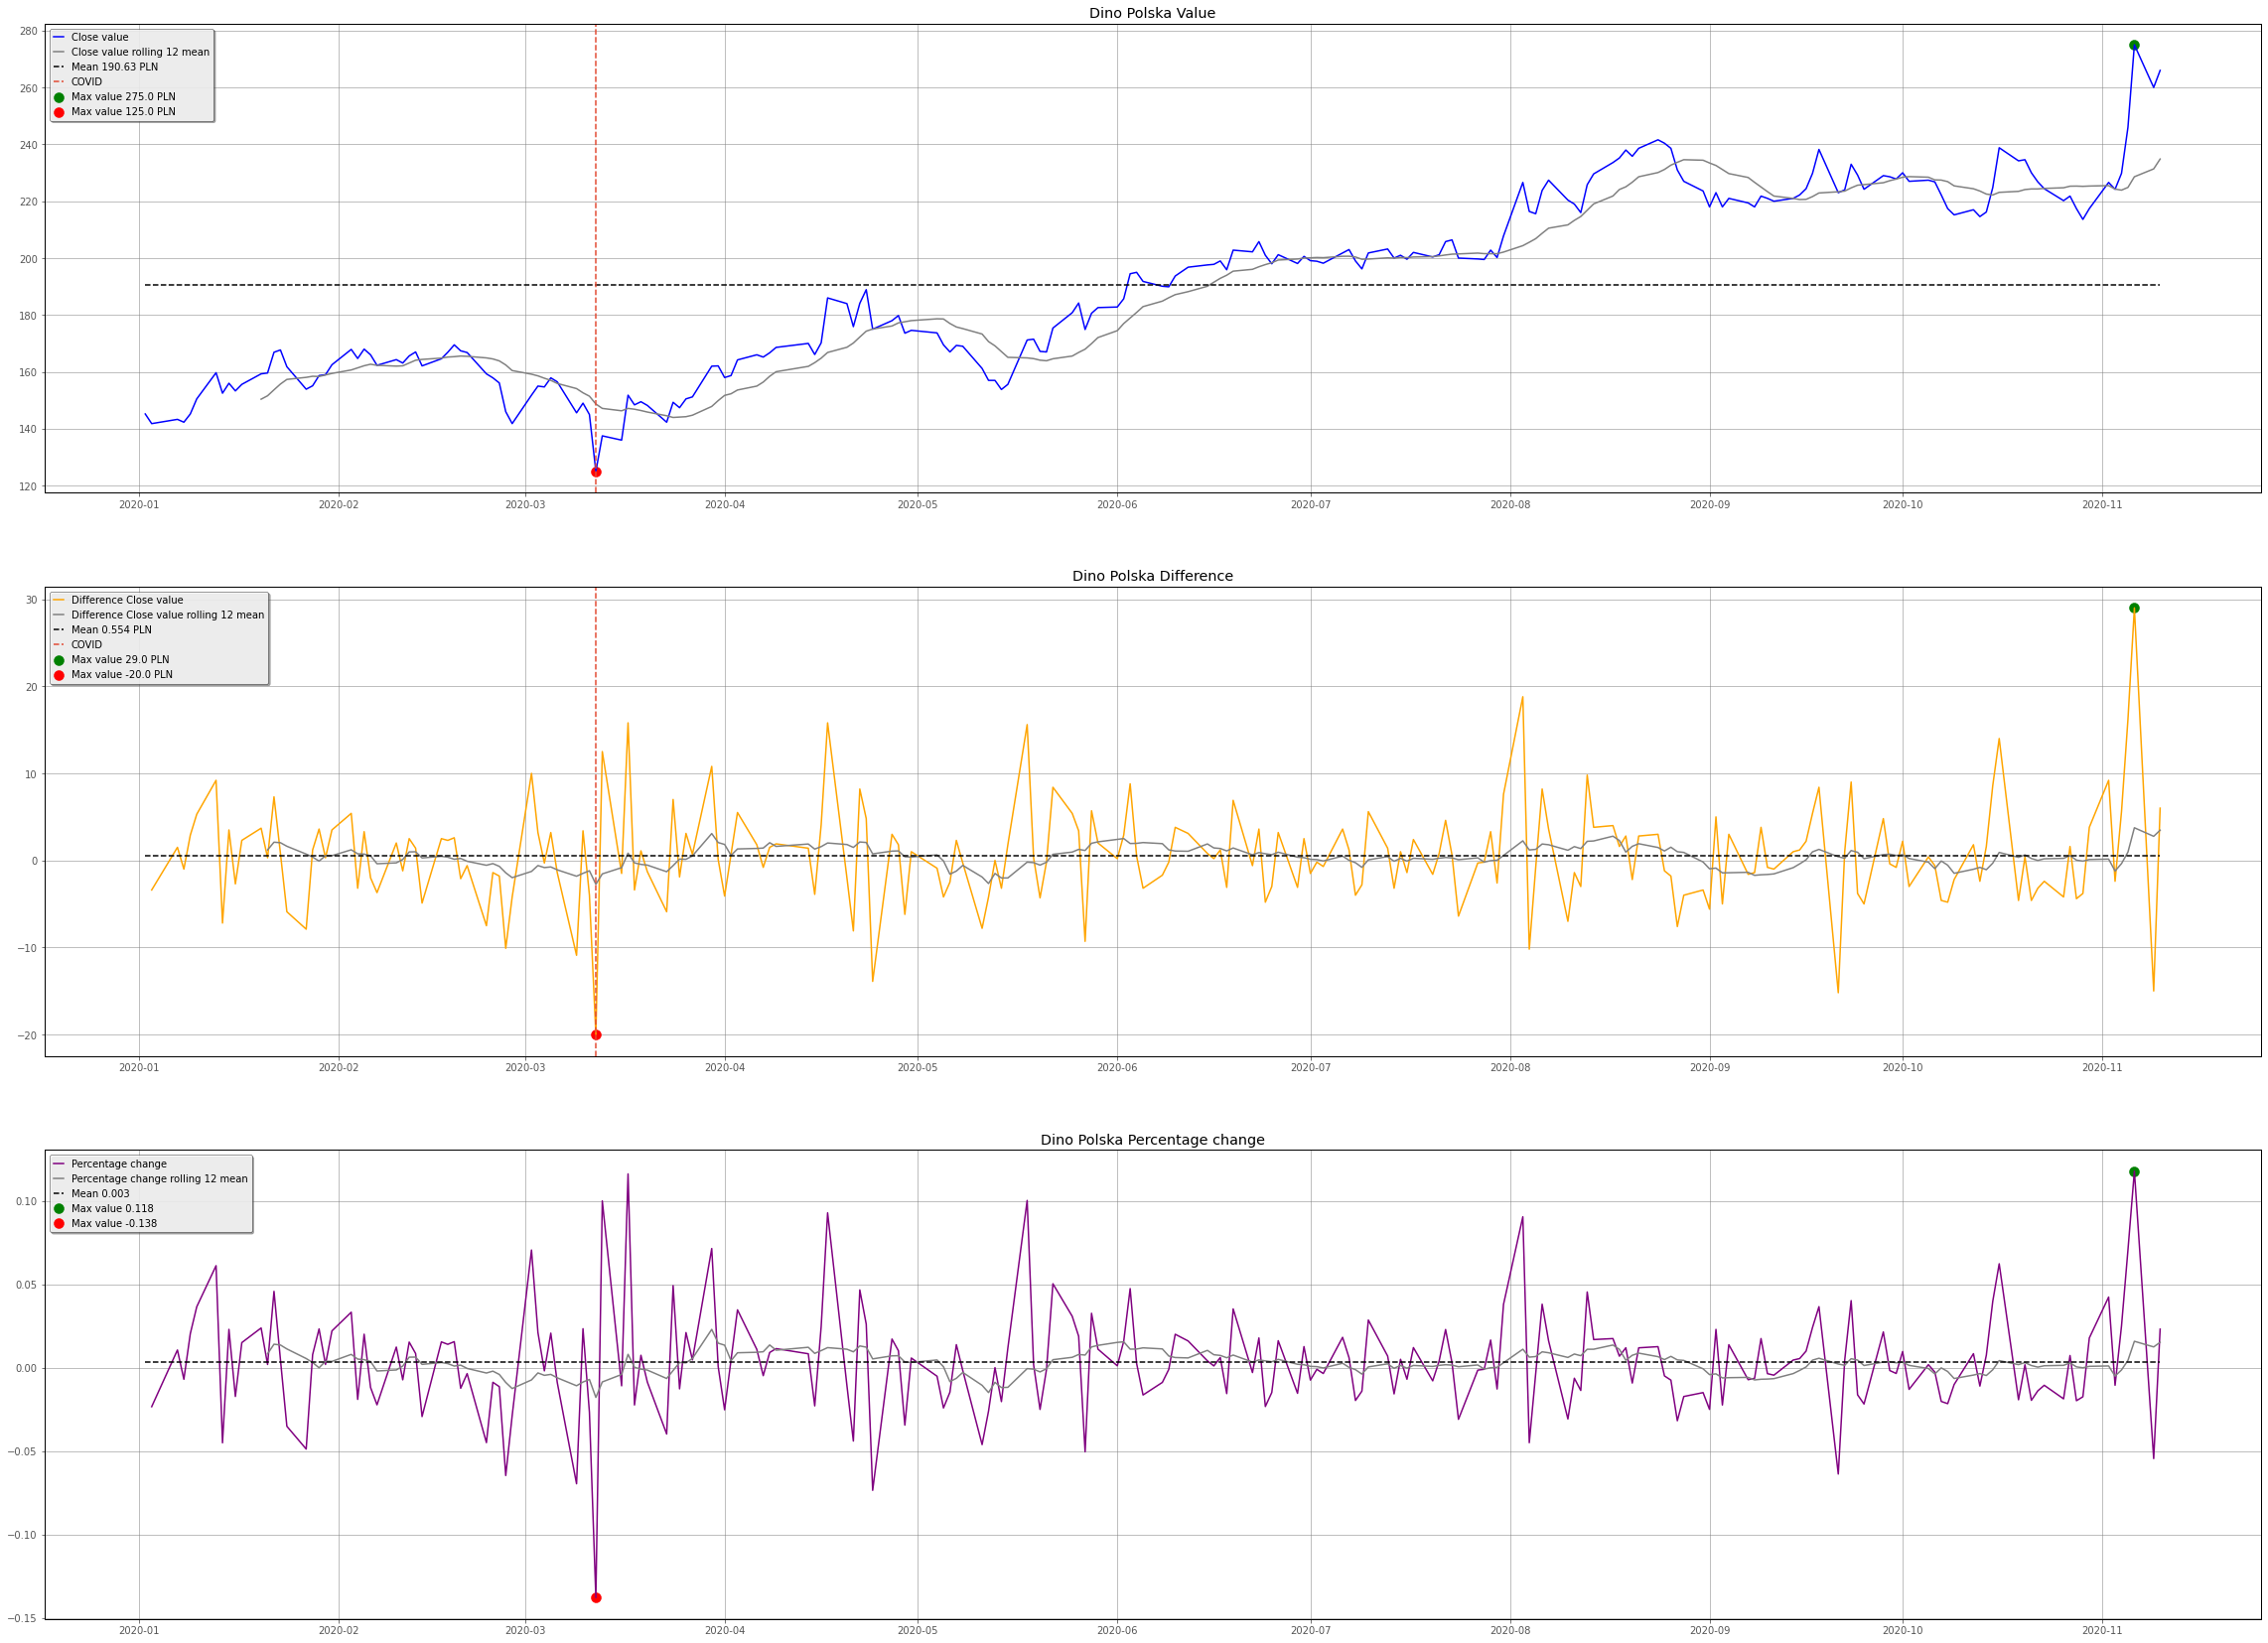

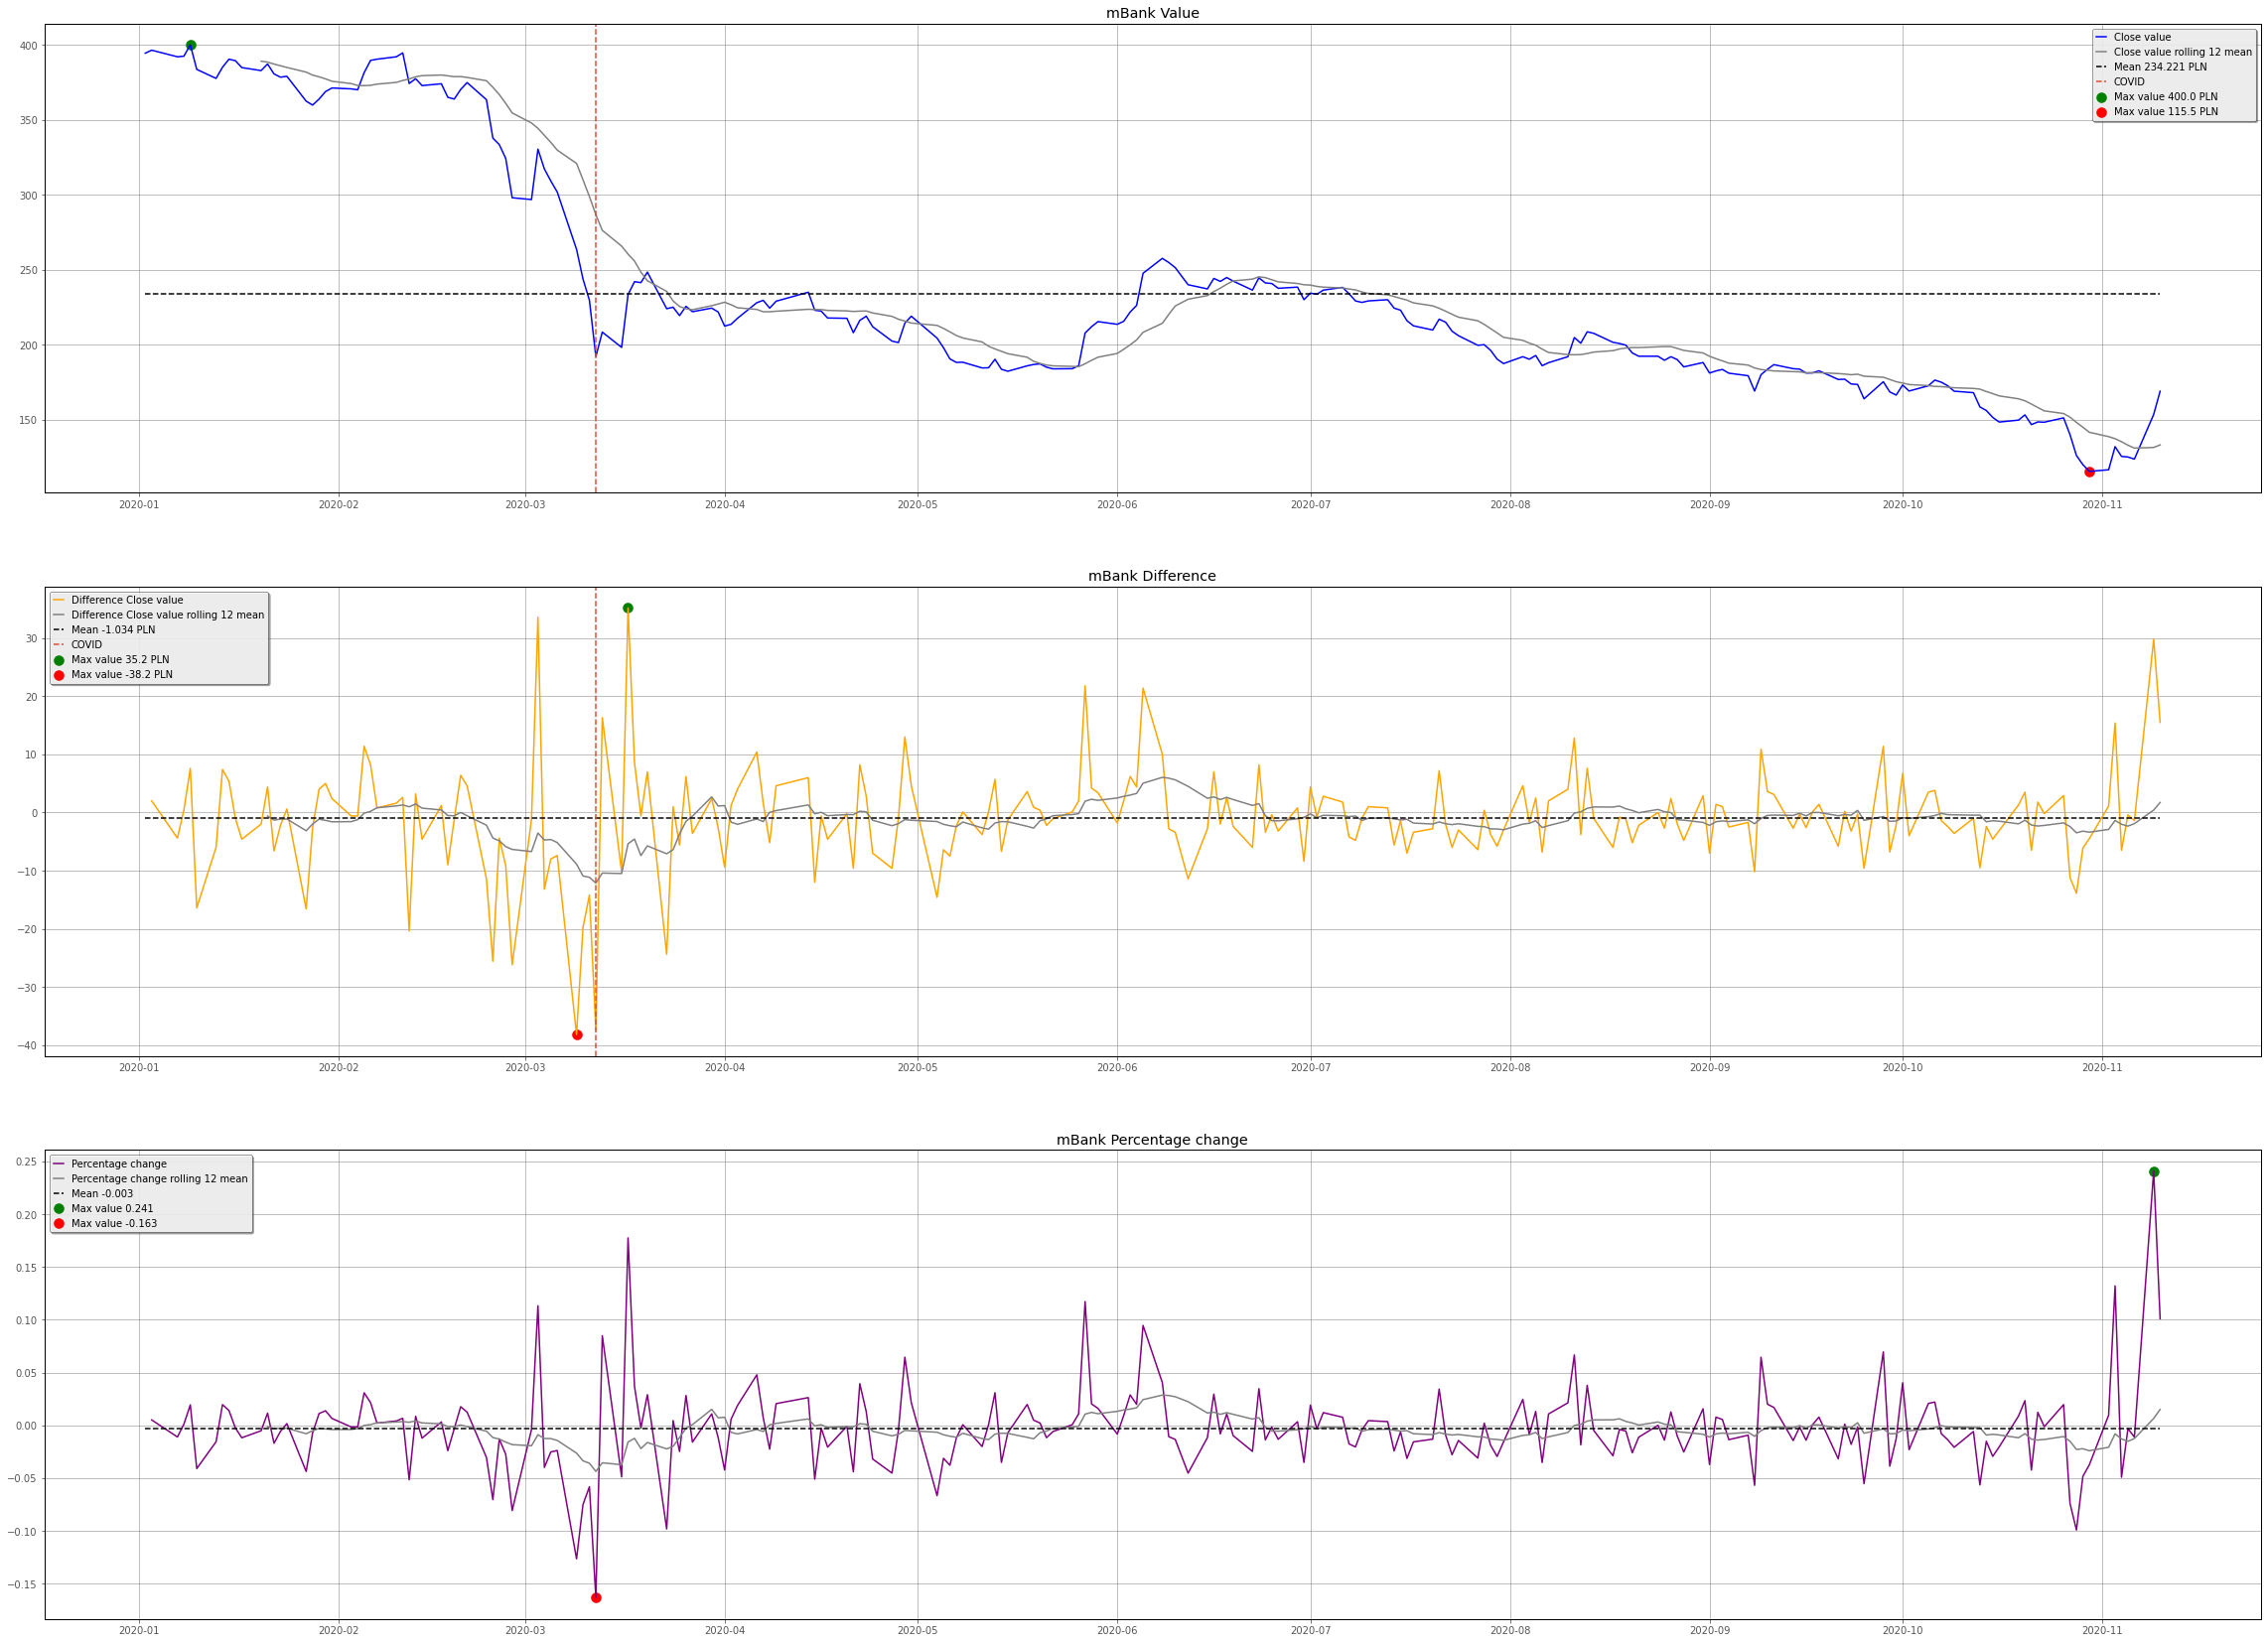

In [92]:
import warnings
warnings.filterwarnings('ignore')
for i in range(df['Stock_name'].nunique()):
  tmp = df[df['Stock_name'] == df['Stock_name'].unique()[i]]
  tmp['Mean'] = tmp['Close'].mean()
  tmp['Mean_diff'] = tmp['Close'].diff().mean()
  tmp['Mean_pct_change'] = tmp['Close'].pct_change().mean()
  plt.figure(figsize=(40,40))
  #Stock value
  plt.subplot(4,1,1)
  plt.plot(tmp['Close'],color = 'blue',label = 'Close value')
  plt.plot(tmp['Close'].rolling(12).mean(),color = 'gray',label = 'Close value rolling 12 mean')
  plt.plot(tmp['Mean'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean'].values[0].round(3)) + " PLN")
  plt.scatter(tmp['Close'].idxmax(), tmp['Close'].max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].max()) + " PLN")
  plt.scatter(tmp['Close'].idxmin(), tmp['Close'].min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].min()) + " PLN")
  plt.axvline(x = tmp['Close'].pct_change().idxmin(), linestyle ='dashed', label = 'COVID')
  plt.title(df['Stock_name'].unique()[i] + ' Value')
  plt.legend()
  plt.grid()
  #Difference value
  plt.subplot(4,1,2)
  plt.plot(tmp['Close'].diff(),color = 'orange',label = 'Difference Close value')
  plt.plot(tmp['Close'].diff().rolling(12).mean(),color = 'gray',label = 'Difference Close value rolling 12 mean')
  plt.plot(tmp['Mean_diff'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean_diff'].values[0].round(3)) + " PLN")
  plt.scatter(tmp['Close'].diff().idxmax(), tmp['Close'].diff().max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].diff().round(3).max()) + " PLN")
  plt.scatter(tmp['Close'].diff().idxmin(), tmp['Close'].diff().min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].diff().round(3).min()) + " PLN")
  plt.axvline(x = tmp['Close'].pct_change().idxmin(), linestyle ='dashed', label = 'COVID')
  plt.title(df['Stock_name'].unique()[i] + ' Difference')
  plt.legend()
  plt.grid()

  #Stock value percentage change
  plt.subplot(4,1,3)
  plt.plot(tmp['Close'].pct_change(), color = 'purple', label = 'Percentage change')
  plt.plot(tmp['Close'].pct_change().rolling(12).mean(), color = 'gray', label = 'Percentage change rolling 12 mean')
  plt.plot(tmp['Mean_pct_change'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean_pct_change'].values[0].round(3)))
  plt.scatter(tmp['Close'].pct_change().idxmax(), tmp['Close'].pct_change().max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).max()))
  plt.scatter(tmp['Close'].pct_change().idxmin(), tmp['Close'].pct_change().min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).min()))
  plt.title(df['Stock_name'].unique()[i] + ' Percentage change')
  plt.grid()
  plt.legend()
  plt.show()


  print(2*"\n")

> # AR(1)

>>## Prepare Data Frames

In [33]:
#Alior Bank Data Frame
alior = df[df['Stock_name'] == 'Alior Bank'].reset_index()
alior['Percentage_change'] = alior['Close'].pct_change(1)
print(alior['Stock_name'][0])
print(alior.describe())

print("-"*25)

#CD Projekt Data Frame
cdprojekt = df[df['Stock_name'] == 'CD Projekt'].reset_index()
cdprojekt['Percentage_change'] = cdprojekt['Close'].pct_change().fillna(0)
print(cdprojekt['Stock_name'][0])
print(cdprojekt.describe())

print("-"*25)

#Dino Polska Data Frame
dino = df[df['Stock_name'] == 'Dino Polska'].reset_index()
dino['Percentage_change'] = dino['Close'].pct_change().fillna(0)
print(dino['Stock_name'][0])
print(dino.describe())


print("-"*25)

#mBank Data Frame
mbank = df[df['Stock_name'] == 'mBank'].reset_index()
mbank['Percentage_change'] = mbank['Close'].pct_change().fillna(0)
print(mbank['Stock_name'][0])
print(mbank.describe())

Alior Bank
            Close  Percentage_change
count  219.000000         218.000000
mean    17.183973          -0.001948
std      5.181720           0.041086
min     11.335000          -0.198799
25%     13.872500          -0.019899
50%     14.975000          -0.003695
75%     17.720000           0.011844
max     29.900000           0.159341
-------------------------
CD Projekt
            Close  Percentage_change
count  219.000000         219.000000
mean   357.806849           0.001614
std     53.180274           0.031704
min    216.100000          -0.139044
25%    308.850000          -0.015385
50%    371.100000           0.002038
75%    400.950000           0.018447
max    460.800000           0.128644
-------------------------
Dino Polska
            Close  Percentage_change
count  219.000000         219.000000
mean   190.629680           0.003253
std     31.367791           0.031341
min    125.000000          -0.137931
25%    162.800000          -0.013992
50%    194.500000         

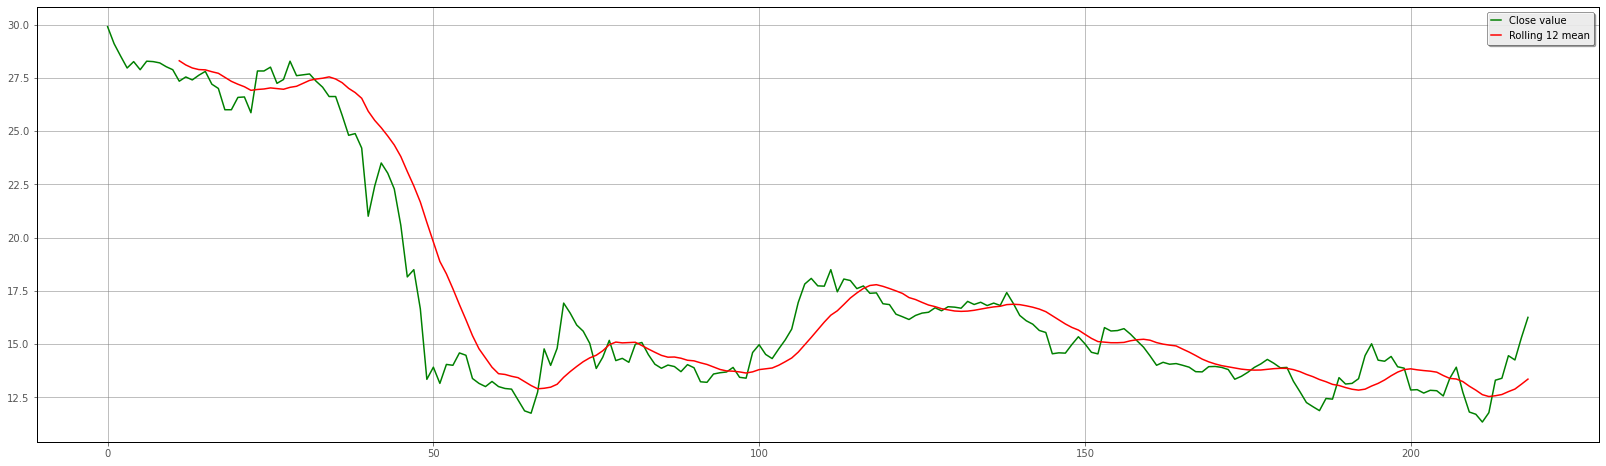

In [87]:
plt.figure(figsize=(28,8))
plt.plot(alior['Close'], color = 'green', label = 'Close value')
plt.plot(alior['Close'].rolling(12).mean(), color = 'red', label = 'Rolling 12 mean')
plt.grid()
plt.legend()
plt.show()

>>## The ACF and PACF

In [35]:
def acf_and_pacf(data_frame,column_name,n_lags):
  sgt.plot_acf(data_frame[column_name].iloc[1:], lags= n_lags, alpha = 0.05, zero = False)
  plt.grid()
  plt.title(f'{data_frame["Stock_name"][0]} Autocorrelation function',size = 20)
  plt.show()
  sgt.plot_pacf(data_frame[column_name].iloc[1:], lags = n_lags, alpha = 0.05, zero = False)
  plt.grid()
  plt.title(f'{data_frame["Stock_name"][0]} Parial Autocorrelation function', size = 20 )
  plt.show()

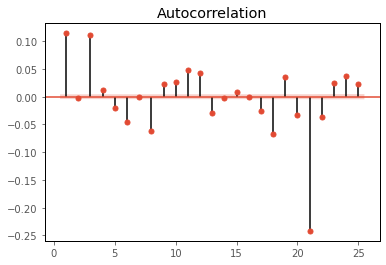

In [55]:
sgt.plot_acf(alior['Percentage_change'][1:], lags = 25, alpha = 0.95, zero = False)
plt.show()

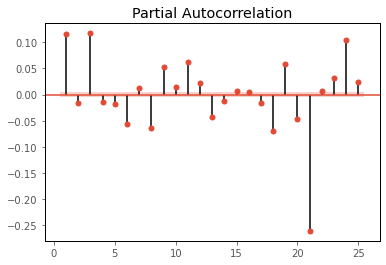

In [56]:
sgt.plot_pacf(alior['Percentage_change'][1:], lags = 25, alpha = 0.95, zero = False)
plt.show()

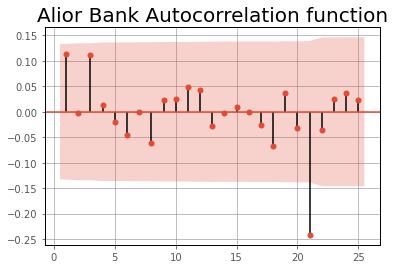

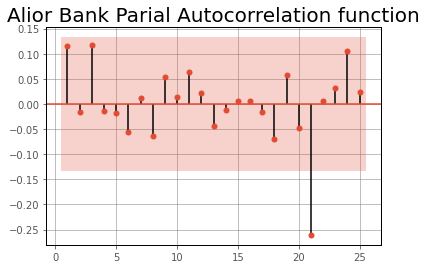

In [58]:
acf_and_pacf(alior,"Percentage_change",25)

>>## ARMA(3,3)

In [27]:
from statsmodels.tsa.arima_model import ARMA
model_ar = ARMA(alior['Percentage_change'][1:], order = (1,1))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Percentage_change   No. Observations:                  218
Model:                     ARMA(1, 1)   Log Likelihood                -614.496
Method:                       css-mle   S.D. of innovations              4.054
Date:                Wed, 11 Nov 2020   AIC                           1236.992
Time:                        17:59:26   BIC                           1250.530
Sample:                             0   HQIC                          1242.460
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1980      0.292     -0.678      0.498      -0.770       0.374
ar.L1.Percentage_change    -0.6969      0.193     -3.602      0.000      -1.076      -0.318
ma.L1.Percentage_change     0.8043      0.162      4.979      0.000       0.488       1.121
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4349           +0.0000j            1.4349            0.5000
MA.1           -1.2434           +0.0000j            1.2434            0.5000
-----------------------------------------------------------------------------
"""

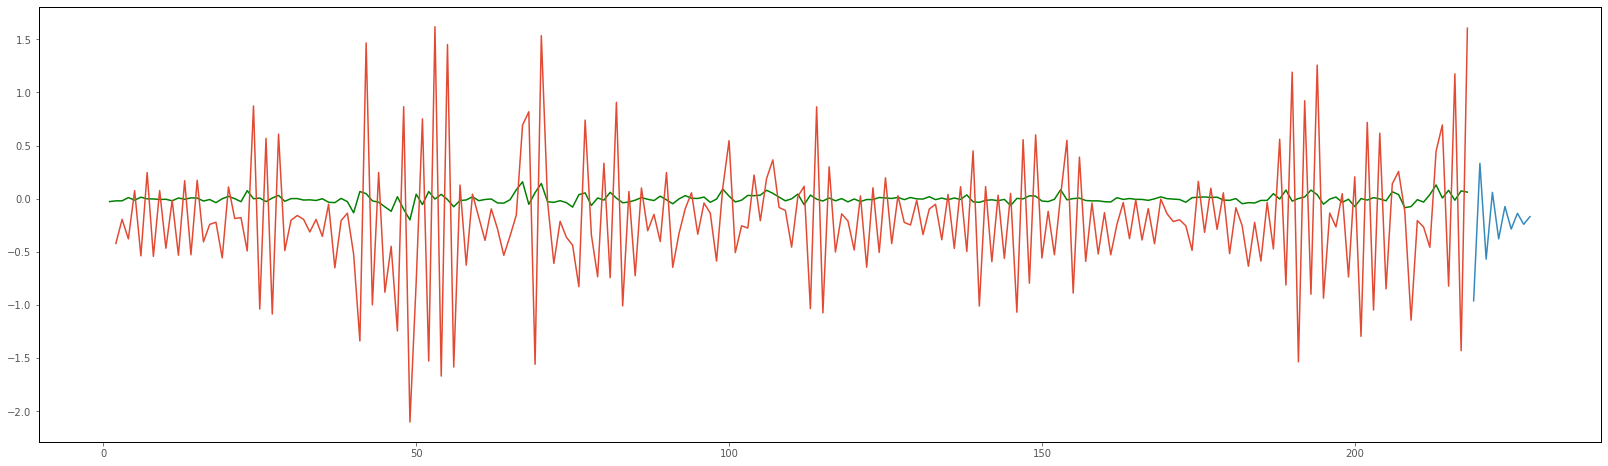

In [78]:
plt.figure(figsize=(28,8))
plt.plot(alior['Percentage_change'], color = 'green')
plt.plot(results_ar.predict())
plt.plot(alior.index[-10:]+10,results_ar.forecast(10, alpha = 0.05)[0])
plt.show()

In [76]:
alior.index[-10:]+10

RangeIndex(start=219, stop=229, step=1)